# **Stage-1:- Creating a Knowledge Base**

- **Problem Statement**
  - Contract / defense data is stored in Excel but it’s hard to search intelligently
  - Traditional keyword search fails when the query wording is different (synonyms / rephrasing)
  - Finding the most relevant past contract descriptions takes too much manual effort
  - Even if you find a match, getting the full context (supplier, program, amount, etc.) from the correct row is difficult
  - A scalable system is needed to support quick retrieval + future AI extraction workflows

- **Proposed Solution**
  - Build a Vector Knowledge Base (KB) from the Excel dataset
  - Convert contract descriptions into semantic embeddings using a transformer model
  - Store embeddings in a FAISS vector index for fast similarity-based retrieval
  - Store all original Excel columns as metadata to return complete structured information
  - Enable searching based on meaning, not only exact words

- **Outcome**
  * Your Excel knowledge base will become **searchable by meaning (semantic search)** instead of only keywords
  * When you give a **new contract description/query**, the system will return the **most similar past contracts** instantly
  * You will be able to retrieve the **best-matching row** even if the words are different (synonyms, rephrasing, short forms)
  * Along with the match, you will also get the **complete row details** (Supplier, Program, Amount, Dates, etc.) because metadata is stored
  * Your extraction pipeline will become **more accurate**, since the LLM can be grounded with relevant historical examples
  * It will reduce **manual lookup time**, improve consistency, and make the process scalable as data grows
  * You will have a reusable **system KB (FAISS + metadata files)** that can be loaded anytime without rebuilding every time
  * This becomes a strong base for building an **agentic workflow** like: Retrieve → Validate → Extract → Store → Report




In [7]:
!pip install -qU pandas faiss-cpu python-dateutil openpyxl langchain langgraph pydantic openai langchain-community langchain-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.4/157.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

In [4]:
import os
import re
import pickle
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer

DEFAULT_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"


def clean_text(text: str) -> str:
    if text is None:
        return ""
    text = str(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


def safe_to_str(x):
    if pd.isna(x):
        return ""
    return str(x).strip()


def build_system_kb_store_all_columns(
    excel_path: str,
    save_dir: str = "system_kb_store",
    model_name: str = DEFAULT_MODEL_NAME,
    batch_size: int = 64,
    embed_column: str = "Description of Contract",
):
    os.makedirs(save_dir, exist_ok=True)

    print(f"\n Loading Excel Knowledge Base: {excel_path}")
    df = pd.read_excel(excel_path)
    print(f" Loaded rows={len(df)} cols={len(df.columns)}")

    if embed_column not in df.columns:
        raise ValueError(f"Embed column '{embed_column}' not found in Excel!")

    df = df.fillna("")

    kb_texts = []
    kb_meta = []

    for idx, row in df.iterrows():
        desc = clean_text(row[embed_column])

        # Skip weak text
        if not desc or len(desc) < 20:
            continue

        meta = {"row_id": int(idx)}
        for col in df.columns:
            meta[col] = safe_to_str(row[col])

        meta[embed_column] = desc

        kb_texts.append(desc)
        kb_meta.append(meta)

    print(f"KB rows kept after cleaning: {len(kb_texts)}")

    if len(kb_texts) == 0:
        print("ERROR: No text rows remained after cleaning.")
        return None, None

    print(f"Loading embedding model: {model_name}")
    embedder = SentenceTransformer(model_name)

    print("Creating embeddings...")
    embeddings = []

    for i in range(0, len(kb_texts), batch_size):
        batch = kb_texts[i : i + batch_size]
        batch_emb = embedder.encode(
            batch, show_progress_bar=True, normalize_embeddings=True
        )
        embeddings.append(batch_emb)

    embeddings = np.vstack(embeddings).astype("float32")
    dim = embeddings.shape[1]

    print(f"Embedding shape: {embeddings.shape}")

    # Cosine similarity via Inner Product (since normalized)
    index = faiss.IndexFlatIP(dim)
    index.add(embeddings)

    index_path = os.path.join(save_dir, "system_kb.faiss")
    meta_path = os.path.join(save_dir, "system_kb_meta.pkl")

    faiss.write_index(index, index_path)
    with open(meta_path, "wb") as f:
        pickle.dump(kb_meta, f)

    print("\n System KB Created Successfully!")
    print(f"Index saved: {index_path}")
    print(f"Meta saved : {meta_path}")

    return index_path, meta_path

# Part 2: Retriever

class SystemKBRetriever:
    def __init__(self, kb_dir="system_kb_store", model_name=DEFAULT_MODEL_NAME):
        index_path = os.path.join(kb_dir, "system_kb.faiss")
        meta_path = os.path.join(kb_dir, "system_kb_meta.pkl")

        if not os.path.exists(index_path) or not os.path.exists(meta_path):
            raise FileNotFoundError("❌ KB files missing. Build KB first.")

        print(f"\n Loading FAISS index: {index_path}")
        self.index = faiss.read_index(index_path)

        print(f"Loading metadata: {meta_path}")
        with open(meta_path, "rb") as f:
            self.meta = pickle.load(f)

        print(f"Loaded KB rows: {len(self.meta)}")
        print(f"Loading embedder: {model_name}")
        self.embedder = SentenceTransformer(model_name)

    def retrieve(self, query_text: str, top_k: int = 5):
        query_text = str(query_text).strip()
        if not query_text:
            return []

        q_emb = self.embedder.encode([query_text], normalize_embeddings=True).astype(
            "float32"
        )

        scores, idxs = self.index.search(q_emb, top_k)
        results = []

        for score, idx in zip(scores[0], idxs[0]):
            if idx < 0:
                continue

            results.append({"score": float(score), "meta": self.meta[idx]})

        return results

# Run Full Pipeline (Build + Search)

if __name__ == "__main__":
    EXCEL_PATH = "/content/sample_data.xlsx"
    KB_DIR = "system_kb_store"

    # Step 1: Build KB
    build_system_kb_store_all_columns(
        excel_path=EXCEL_PATH,
        save_dir=KB_DIR,
        model_name=DEFAULT_MODEL_NAME,
        batch_size=64,
        embed_column="Description of Contract",
    )

    # Step 2: Load KB + Retrieve
    r = SystemKBRetriever(kb_dir=KB_DIR)

    query = "Dell Marketing L.P., Round Rock, Texas, is awarded a single-award, firm-fixed-price blanket purchase agreement"

    hits = r.retrieve(query, top_k=3)

    print("\n" + "=" * 60)
    print("TOP MATCHES")
    print("=" * 60)

    for i, h in enumerate(hits, start=1):
        print(f"\n🔹 Rank: {i}")
        print("Score:", h["score"])
        print("Supplier:", h["meta"].get("Supplier Name", ""))
        print("Market:", h["meta"].get("Market Segment", ""))
        print("System:", h["meta"].get("System Name (Specific)", ""))
        print("Row ID:", h["meta"].get("row_id", ""))



 Loading Excel Knowledge Base: /content/sample_data.xlsx
 Loaded rows=2068 cols=29
KB rows kept after cleaning: 600
Loading embedding model: sentence-transformers/all-MiniLM-L6-v2
Creating embeddings...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Embedding shape: (600, 384)

 System KB Created Successfully!
Index saved: system_kb_store/system_kb.faiss
Meta saved : system_kb_store/system_kb_meta.pkl

 Loading FAISS index: system_kb_store/system_kb.faiss
Loading metadata: system_kb_store/system_kb_meta.pkl
Loaded KB rows: 600
Loading embedder: sentence-transformers/all-MiniLM-L6-v2

TOP MATCHES

🔹 Rank: 1
Score: 0.6228203773498535
Supplier: Dell Inc
Market: Unknown
System: Department of Defense Enterprise Software Initiative (DOD ESI)
Row ID: 379

🔹 Rank: 2
Score: 0.6228203773498535
Supplier: Dell Inc
Market: Unknown
System: Department of Defense Enterprise Software Initiative (DOD ESI)
Row ID: 1

🔹 Rank: 3
Score: 0.6024371385574341
Supplier: 
Market: Unknown
System: Department of Defense Enterprise Software Initiative (DOD ESI)
Row ID: 159


# **Stage-2**

In [1]:
import os
import re
import json
import pickle
import difflib
import datetime
from typing import Annotated, TypedDict, List, Dict, Any, Optional, Tuple

import pandas as pd
import faiss
from dateutil import parser
from dateutil.relativedelta import relativedelta
import getpass

# LangGraph / LangChain
from langchain_core.messages import AnyMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from openai import OpenAI

# Excel formatting
from openpyxl import load_workbook
from openpyxl.styles import PatternFill, Font

In [2]:
## DEBUG LOGGING HELPERS

def log_block(title: str, content: str):
    print("\n" + "=" * 110)
    print(title)
    print("=" * 110)
    print(content)

In [3]:
## CHUNKING HELPERS (NO DATA LOSS)
def chunk_text(text: str, chunk_size: int = 1800, overlap: int = 250) -> List[str]:
    """
    Deterministic chunking: stable + safe + prevents token overflow.
    - chunk_size: number of characters per chunk
    - overlap: overlapping characters to preserve boundaries
    """
    text = str(text)
    if not text.strip():
        return []

    chunks = []
    start = 0
    n = len(text)

    while start < n:
        end = min(start + chunk_size, n)
        chunk = text[start:end].strip()
        if chunk:
            chunks.append(chunk)

        if end >= n:
            break

        start = max(0, end - overlap)

    return chunks


def pick_best_non_empty(values: List[str]) -> str:
    """Return first strong value else empty."""
    for v in values:
        if v and str(v).strip() and str(v).strip().lower() not in ["unknown", "n/a", "not applicable", "none"]:
            return str(v).strip()
    return ""

In [4]:
## RAG RETRIEVER (FAISS + METADATA)
class SystemKBRetriever:
    def __init__(self, kb_dir: str, embed_model: str = "sentence-transformers/all-MiniLM-L6-v2"):
        self.kb_dir = kb_dir
        self.embed_model = embed_model

        index_path = os.path.join(kb_dir, "system_kb.faiss")
        meta_path = os.path.join(kb_dir, "system_kb_meta.pkl")

        if not os.path.exists(index_path) or not os.path.exists(meta_path):
            raise FileNotFoundError(
                f"KB files not found in: {kb_dir}\n"
                f"Expected:\n- {index_path}\n- {meta_path}\n\n"
                f"Build KB first using your KB builder script."
            )
        print(f"Loading FAISS Index: {index_path}")
        self.index = faiss.read_index(index_path)

        print(f"Loading KB Metadata: {meta_path}")
        with open(meta_path, "rb") as f:
            self.meta = pickle.load(f)

        print(f"KB Loaded rows: {len(self.meta)}")

        self.embedder = None

    def _lazy_load_embedder(self):
        if self.embedder is None:
            from sentence_transformers import SentenceTransformer
            self.embedder = SentenceTransformer(self.embed_model)

    def retrieve(self, query_text: str, top_k: int = 3):
        import numpy as np
        query_text = str(query_text).strip()
        if not query_text:
            return []

        self._lazy_load_embedder()

        q_emb = self.embedder.encode([query_text], normalize_embeddings=True).astype("float32")
        scores, idxs = self.index.search(q_emb, top_k)

        results = []
        for score, idx in zip(scores[0], idxs[0]):
            if idx < 0:
                continue
            results.append({"score": float(score), "meta": self.meta[idx]})
        return results

In [5]:
# CONFIGURATION & FILE PATHS
TAXONOMY_PATH = "/content/taxonomy.json"
SUPPLIERS_PATH = "/content/suppliers.json"
INPUT_EXCEL_PATH = "/content/source_file.xlsx"
OUTPUT_CSV_PATH = "Processed_Defense_Data.csv"
RAG_KB_DIR = "/content/system_kb_store"

In [6]:
## LLM CLIENT SETUP (OpenRouter)

OPENROUTER_API_KEY_ENV = "OPENROUTER_API_KEY"

if OPENROUTER_API_KEY_ENV not in os.environ:
    os.environ[OPENROUTER_API_KEY_ENV] = getpass.getpass("Enter the OpenRouter API Key: ")

client = OpenAI(
    api_key=os.environ.get(OPENROUTER_API_KEY_ENV),
    base_url="https://openrouter.ai/api/v1",
)

Enter the OpenRouter API Key: ··········


In [7]:
OPENROUTER_MODEL = "openai/gpt-4o-mini"

# Token control per stage
MAXTOK_STAGE2 = 250
MAXTOK_STAGE3 = 850
MAXTOK_STAGE4 = 350
MAXTOK_STAGE7 = 350

retriever = SystemKBRetriever(kb_dir=RAG_KB_DIR)

Loading FAISS Index: /content/system_kb_store/system_kb.faiss
Loading KB Metadata: /content/system_kb_store/system_kb_meta.pkl
KB Loaded rows: 600


In [8]:
## LOAD JSON HELPERS
def load_json_file(filename, default_value):
    try:
        with open(filename, "r", encoding="utf-8") as f:
            print(f"Loaded: {filename}")
            return json.load(f)
    except Exception as e:
        print(f"Warning: Could not load {filename} ({e}). Using default.")
        return default_value


raw_taxonomy = load_json_file(TAXONOMY_PATH, {})
TAXONOMY_STR = json.dumps(raw_taxonomy, separators=(",", ":"))

SUPPLIER_LIST = load_json_file(SUPPLIERS_PATH, [
    "Dell Inc", "Boeing", "Lockheed Martin", "Raytheon Technologies",
    "Northrop Grumman", "L3Harris", "BAE Systems", "General Dynamics"
])

Loaded: /content/taxonomy.json
Loaded: /content/suppliers.json


In [9]:
## RULE BOOK + GEOGRAPHY

RULE_BOOK = {
    "defensive_countermeasures": {
        "triggers": ["flare", "chaff", "countermeasure", "decoy", "mju-", "ale-"],
        "guidance": "Market Segment: 'C4ISR Systems', System Type (General): 'Defensive Systems', Specific: 'Defensive Aid Suite'"
    },
    "radars_and_sensors": {
        "triggers": ["radar", "sonar", "sensor", "an/apy", "an/tpy"],
        "guidance": "Market Segment: 'C4ISR Systems', System Type (General): 'Sensors'"
    },
    "ammunition": {
        "triggers": ["cartridge", "round", "projectile", " 5.56", " 7.62", "ammo"],
        "guidance": "Market Segment: 'Weapon Systems', System Type (General): 'Ammunition'"
    }
}

GEOGRAPHY_MAPPING = {
    "Sub-Saharan Africa": [
        "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde",
        "Central African Republic", "Chad", "Congo, Democratic Republic of", "Congo, Republic of",
        "Djibouti", "Equatorial Guinea", "Eritrea", "Eswatini", "Ethiopia", "Gabon", "Gambia",
        "Ghana", "Guinea", "Guinea-Bissau", "Ivory Coast", "Kenya", "Lesotho", "Liberia",
        "Madagascar", "Malawi", "Mali", "Mauritius", "Mozambique", "Namibia", "Niger",
        "Nigeria", "Rwanda", "Senegal", "Seychelles", "Sierra Leone", "Somalia", "South Africa",
        "South Sudan", "Sudan", "Tanzania", "Togo", "Uganda", "Zambia", "Zimbabwe"
    ],
    "Asia-Pacific": [
        "Australia", "Brunei", "Cambodia", "China", "Hong Kong", "Indonesia", "Japan", "Laos",
        "Malaysia", "Mongolia", "Myanmar", "New Zealand", "North Korea", "Papua New Guinea",
        "Philippines", "Singapore", "South Korea", "Taiwan", "Thailand", "Vietnam"
    ],
    "Europe": [
        "Albania", "Austria", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus",
        "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece",
        "Hungary", "Iceland", "Ireland", "Italy", "Kosovo", "Latvia", "Lithuania", "Luxembourg",
        "Malta", "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal",
        "Romania", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey",
        "Ukraine", "United Kingdom"
    ],
    "Latin America": [
        "Argentina", "Bahamas", "Barbados", "Belize", "Bolivia", "Brazil", "Chile", "Colombia",
        "Costa Rica", "Cuba", "Curacao", "Dominican Republic", "Ecuador", "El Salvador", "Guatemala",
        "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Paraguay",
        "Peru", "Suriname", "Trinidad and Tobago", "Uruguay", "Venezuela"
    ],
    "Middle East and North Africa": [
        "Algeria", "Bahrain", "Egypt", "Iran", "Iraq", "Israel", "Jordan", "Kuwait", "Lebanon",
        "Libya", "Mauritania", "Morocco", "Oman", "Qatar", "Saudi Arabia", "Syria", "Tunisia",
        "United Arab Emirates", "Yemen"
    ],
    "North America": ["Canada", "USA"],
    "Russia & CIS": [
        "Armenia", "Azerbaijan", "Belarus", "Kazakhstan", "Kyrgyzstan", "Moldova", "Russia",
        "Tajikistan", "Turkmenistan", "Uzbekistan"
    ],
    "South Asia": [
        "Afghanistan", "Bangladesh", "India", "Maldives", "Nepal", "Pakistan", "Sri Lanka"
    ],
    "Unknown": [
        "Andorra", "Antigua and Barbuda", "Bhutan", "Comoros", "Dominica", "Federated States of Micronesia",
        "Fiji", "Grenada", "Kiribati", "Liechtenstein", "Marshall Islands", "Monaco", "Nauru", "Palau",
        "Palestine", "Puerto Rico", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines",
        "Samoa", "San Marino", "Sao Tom and Principe", "Solomon Islands", "Timor-Leste", "Tonga", "Tuvalu",
        "Unknown", "Vanuatu", "Vatican City", "Western Sahara"
    ]
}


In [10]:
## BASE HELPERS (Supplier + Dates + Region + Designators)

PROGRAM_TYPE_ALLOWED = [
    "Procurement",
    "Training",
    "MRO/Support",
    "RDT&E",
    "Upgrade",
    "Other Service"
]

def normalize_program_type(pt: str) -> str:
    if not pt:
        return "Other Service"

    t = str(pt).strip().lower()

    if any(k in t for k in ["mro", "support", "maintenance", "repair", "overhaul", "sustainment", "logistics"]):
        return "MRO/Support"
    if "training" in t:
        return "Training"
    if any(k in t for k in ["rdte", "research", "development", "prototype", "test and evaluation"]):
        return "RDT&E"
    if any(k in t for k in ["upgrade", "modernization", "modification"]):
        return "Upgrade"
    if any(k in t for k in ["procure", "buy", "purchase", "production", "delivery"]):
        return "Procurement"

    return "Other Service"

def get_best_supplier_match(extracted_name: str) -> str:
    if not extracted_name or str(extracted_name).strip().lower() in ["unknown", "n/a", "not applicable"]:
        return "Unknown"

    raw_name = str(extracted_name).strip()
    raw_lower = raw_name.lower()
    valid_suppliers = sorted([str(s) for s in SUPPLIER_LIST], key=len, reverse=True)

    # 1) Exact match
    for s in valid_suppliers:
        if s.lower() == raw_lower:
            return s

    # 2) Known inside extracted
    for s in valid_suppliers:
        if len(s) > 3 and s.lower() in raw_lower:
            return s

    # 3) Extracted inside known
    for s in valid_suppliers:
        if raw_lower in s.lower():
            return s

    # 4) Strict fuzzy
    matches = difflib.get_close_matches(raw_name, valid_suppliers, n=1, cutoff=0.8)
    if matches:
        return matches[0]

    return raw_name


def extract_awardee_supplier_strict(paragraph: str) -> Tuple[str, str]:
    text = str(paragraph).strip()

    patterns = [
        r"^([A-Z][A-Za-z0-9&\-\.\s]+?),\s+.*?\s+(?:is|was|has been)\s+awarded\b",
        r"^([A-Z][A-Za-z0-9&\-\.\s]+?),\s+.*?\s+received\s+an?\s+award\b",
    ]

    for pat in patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            raw_supplier = m.group(1).strip()
            final_supplier = get_best_supplier_match(raw_supplier)
            return final_supplier, raw_supplier

    return "Unknown", "Not Found"


def calculate_mro_months(start_date_str, end_date_text, program_type):
    if program_type != "MRO/Support":
        return "Not Applicable"
    try:
        if not start_date_str or not end_date_text:
            return "Not Applicable"

        start = pd.to_datetime(start_date_str, dayfirst=True)
        end = parser.parse(str(end_date_text), fuzzy=True)

        diff = relativedelta(end, start)
        total_months = diff.years * 12 + diff.months
        return str(max(0, int(total_months)))
    except:
        return "Not Applicable"


def get_region_for_country(country_name):
    if not country_name or str(country_name).strip().lower() in ["unknown", "n/a", "not applicable"]:
        return "Unknown"

    clean = str(country_name).strip().lower()

    if clean in ["us", "usa", "u.s.", "united states", "united states of america"]:
        return "North America"
    if clean in ["uk", "u.k.", "britain", "great britain"]:
        return "Europe"

    for region, countries in GEOGRAPHY_MAPPING.items():
        if any(c.lower() == clean for c in countries):
            return region

    return "Unknown"


DESIGNATOR_PATTERNS = [
    r"\bDDG[-\s]?\d+\b", r"\bCVN[-\s]?\d+\b", r"\bSSN[-\s]?\d+\b",
    r"\bLCS[-\s]?\d+\b", r"\bLPD[-\s]?\d+\b", r"\bLHA[-\s]?\d+\b", r"\bLHD[-\s]?\d+\b",
    r"\bF-\d+\b", r"\bB-\d+\b", r"\bC-\d+\b", r"\bA-\d+\b",
    r"\bMQ-\d+\b", r"\bRQ-\d+\b",
    r"\bAN\/[A-Z0-9\-]+\b",
    r"\b(AIM|AGM|SM|RIM|MIM)-\d+\b",
]

def extract_designators(text: str):
    text = str(text)
    found = []
    for pat in DESIGNATOR_PATTERNS:
        found.extend(re.findall(pat, text, flags=re.IGNORECASE))
    cleaned = [f.upper().replace(" ", "").replace("--", "-") for f in found]
    final, seen = [], set()
    for x in cleaned:
        if x not in seen:
            final.append(x)
            seen.add(x)
    return final


def detect_piloting_rule_based(text: str, designators: List[str]) -> str:
    t = str(text).lower()

    if any(d.startswith(("MQ-", "RQ-")) for d in designators):
        return "Uncrewed"
    if any(k in t for k in ["unmanned", "uav", "drone", "autonomous"]):
        return "Uncrewed"

    if any(d.startswith(("DDG", "CVN", "SSN", "LCS", "LPD", "LHA", "LHD")) for d in designators):
        return "Crewed"
    if "uss " in t:
        return "Crewed"

    return "Not Applicable"



In [11]:
def extract_award_value_million_strict(paragraph: str) -> str:
    """
    Extract contract AWARD value strictly from award patterns only.
    Avoids funding amounts later in the paragraph.
    Output: string in million format like '12.015'
    """
    t = str(paragraph)

    patterns = [
        r"\bis awarded a\s+\$([\d,]+(?:\.\d+)?)\b",
        r"\bare awarded an estimated aggregate ceiling of\s+\$([\d,]+(?:\.\d+)?)\b",
        r"\bare awarded an?\s+\$([\d,]+(?:\.\d+)?)\b",
        r"\bceiling of\s+\$([\d,]+(?:\.\d+)?)\b",
    ]

    for pat in patterns:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            try:
                val = float(m.group(1).replace(",", ""))
                return f"{val/1_000_000:.3f}"
            except:
                pass

    return ""


def detect_quantity_should_be_na(paragraph: str) -> bool:
    """
    If paragraph contains many item quantities -> treat Quantity as Not Applicable.
    Example3: 483 missiles, 82 missiles, 156 missiles, 198 containers...
    That is NOT a single contract-level quantity.
    """
    t = str(paragraph)

    # Count numeric patterns that look like item quantities
    qty_candidates = re.findall(r"\b(\d{1,5})\b", t)

    # If too many numbers appear, it's almost always a line-item contract
    if len(qty_candidates) >= 12:
        return True

    # Specific strong markers for line-item heavy paragraphs
    if any(k in t.lower() for k in ["as follows:", "lot", "containers", "spare", "tail cap", "guidance unit"]):
        return True

    return False


def normalize_currency(cur: str) -> str:
    if not cur:
        return "USD$"
    c = str(cur).strip().upper()
    if c in ["USD", "US$", "$", "US DOLLAR", "DOLLARS"]:
        return "USD$"
    return c


In [12]:
# ==============================================================================
# STAGE 5 SPLIT ENGINE (FINAL PATCH: LINE-ITEM + OPERATOR SPLIT + WORD NUMBERS)
# ==============================================================================

def word_to_int(token: str) -> Optional[int]:
    """
    Converts word numbers to int:
    eight -> 8, twenty one -> 21

    Supports 0-99 safely.
    Returns None if not a valid word-number.
    """
    if not token:
        return None

    t = str(token).strip().lower()
    t = t.replace("-", " ")
    parts = [p for p in t.split() if p]

    ones = {
        "zero": 0, "one": 1, "two": 2, "three": 3, "four": 4, "five": 5,
        "six": 6, "seven": 7, "eight": 8, "nine": 9, "ten": 10,
        "eleven": 11, "twelve": 12, "thirteen": 13, "fourteen": 14,
        "fifteen": 15, "sixteen": 16, "seventeen": 17, "eighteen": 18,
        "nineteen": 19
    }

    tens = {
        "twenty": 20, "thirty": 30, "forty": 40, "fifty": 50,
        "sixty": 60, "seventy": 70, "eighty": 80, "ninety": 90
    }

    # single word
    if len(parts) == 1:
        if parts[0] in ones:
            return ones[parts[0]]
        if parts[0] in tens:
            return tens[parts[0]]
        return None

    # two words: "twenty one"
    if len(parts) == 2:
        if parts[0] in tens and parts[1] in ones:
            return tens[parts[0]] + ones[parts[1]]
        return None

    return None


def parse_qty_token(qty_token: str) -> Optional[int]:
    """
    Converts numeric token or word-number token into int.
    """
    if qty_token is None:
        return None
    s = str(qty_token).strip().lower()

    # numeric
    if re.fullmatch(r"\d+", s):
        return int(s)

    # word-number
    return word_to_int(s)


def parse_fms_countries(paragraph: str) -> List[str]:
    """
    Extract FMS customer countries list.
    Example: 'governments of Australia, Bahrain, Belgium...'
    """
    text = str(paragraph)

    m = re.search(
        r"governments of (.+?)(?:\.\s| Work will be performed| Fiscal| This contract|$)",
        text,
        flags=re.IGNORECASE | re.DOTALL
    )
    if not m:
        return []

    block = m.group(1)
    raw = re.split(r",|\band\b", block)

    countries = []
    for c in raw:
        c = c.strip()
        if 2 < len(c) <= 40:
            countries.append(c)

    final, seen = [], set()
    for c in countries:
        if c.lower() not in seen:
            final.append(c)
            seen.add(c.lower())

    return final


def detect_multiple_supplier_award(paragraph: str) -> bool:
    """
    Detect Example2 pattern:
    Many suppliers listed with semicolons + "are awarded ..."
    """
    t = str(paragraph).strip()
    if ";" in t and re.search(r"\bare awarded\b", t, flags=re.IGNORECASE):
        if re.search(r"\([A-Z0-9]{6,}\)", t):
            return True
    return False


def parse_line_item_operator_allocations(paragraph: str) -> List[Dict[str, str]]:
    """
    ✅ Extract line-item splits like:

    '483 AIM-9X ... missiles (212 for the Navy, 187 for the Air Force and 84 for FMS customers);'
    '82 AIM-9X ... missiles (eight for the Navy, eight for the Air Force and 66 for FMS customers);'

    Output:
      [
        {"item_name": "...", "operator":"Navy", "quantity":"212", "g2g_b2g":"B2G"},
        {"item_name": "...", "operator":"Air Force", "quantity":"187", "g2g_b2g":"B2G"},
        {"item_name": "...", "operator":"Foreign Assistance", "quantity":"84", "g2g_b2g":"G2G"}
      ]
    """
    text = str(paragraph)

    # This finds: <total qty> <item desc> ( <allocation block> )
    # Example: 483 AIM-9X ... missiles (212 for the Navy, 187 for the Air Force and 84 for FMS customers)
    item_pattern = r"\b(\d+)\s+(.+?)\s*\(([^)]*for[^)]*)\)"
    matches = re.findall(item_pattern, text, flags=re.IGNORECASE)

    results = []

    for total_qty, item_desc, alloc_block in matches:
        item_desc_clean = re.sub(r"\s+", " ", item_desc).strip(" ;,.-")

        # --- BRANCH allocations (digit or word-number)
        branch_pattern = r"\b(\d+|[A-Za-z\-]+)\s+for\s+the\s+(Navy|Air Force|Army|Marine Corps|Space Force|Coast Guard)\b"
        for qty_token, op in re.findall(branch_pattern, alloc_block, flags=re.IGNORECASE):
            qty_val = parse_qty_token(qty_token)
            if qty_val is None:
                continue

            results.append({
                "item_name": item_desc_clean,
                "operator": op.title(),
                "quantity": str(qty_val),
                "g2g_b2g": "B2G"
            })

        # --- FMS allocations (digit or word-number)
        fms_pattern = r"\b(\d+|[A-Za-z\-]+)\s+for\s+(?:Foreign Military Sales\s*\(FMS\)\s*customers|Foreign Military Sales\s*customers|FMS\s*customers|FMS)\b"
        for qty_token in re.findall(fms_pattern, alloc_block, flags=re.IGNORECASE):
            qty_val = parse_qty_token(qty_token)
            if qty_val is None:
                continue

            results.append({
                "item_name": item_desc_clean,
                "operator": "Foreign Assistance",
                "quantity": str(qty_val),
                "g2g_b2g": "G2G"
            })

    return results


def split_rows_engine(base_row: dict, paragraph: str) -> List[dict]:
    """
    ✅ FINAL STAGE5 Split Engine (Your required behavior)

    SPLITS:
    1) Multi-supplier award => Supplier Name = Multiple (NO supplier split)
    2) Line-item + operator allocation split (Navy/AirForce/FMS)
    3) FMS country split ONLY for G2G rows

    ✅ Only split fields are modified, rest remain unchanged.
    """
    paragraph = str(paragraph).strip()
    row = base_row.copy()

    split_reasons = []

    # ------------------------------------------------------------------
    # 1) MULTIPLE SUPPLIER AWARD (Example2)
    # ------------------------------------------------------------------
    if detect_multiple_supplier_award(paragraph):
        row["Supplier Name"] = "Multiple"
        row["Supplier Name Evidence"] = "Multiple Suppliers (Detected)"
        row["Split Flag"] = "No"
        row["Split Reason"] = "Multiple supplier award detected (no supplier split)"
        return [row]

    rows = [row]

    # ------------------------------------------------------------------
    # 2) LINE-ITEM + OPERATOR SPLIT (Your expected output)
    # ------------------------------------------------------------------
    item_allocs = parse_line_item_operator_allocations(paragraph)

    if item_allocs:
        split_reasons.append("Line-item operator allocation split")

        new_rows = []
        for r in rows:
            for alloc in item_allocs:
                rr = r.copy()

                # ✅ Only split fields change
                rr["Customer Operator"] = alloc["operator"]
                rr["Quantity"] = alloc["quantity"]
                rr["G2G/B2G"] = alloc["g2g_b2g"]

                # ✅ Make system labels reflect line-item name (matches your expected output)
                rr["System Name (General)"] = alloc["item_name"]
                rr["System Name (Specific)"] = alloc["item_name"]

                new_rows.append(rr)

        rows = new_rows

    # ------------------------------------------------------------------
    # 3) FMS COUNTRY SPLIT (ONLY for G2G rows)
    # ------------------------------------------------------------------
    fms_countries = parse_fms_countries(paragraph)
    if fms_countries:
        split_reasons.append("FMS country split")

        final_rows = []
        for r in rows:
            is_g2g = str(r.get("G2G/B2G", "")).strip().upper() == "G2G"
            is_fms_operator = "foreign" in str(r.get("Customer Operator", "")).lower()

            if is_g2g or is_fms_operator:
                for c in fms_countries:
                    rr = r.copy()
                    rr["Customer Country"] = normalize_country_name(c)
                    rr["Customer Region"] = get_region_for_country(rr["Customer Country"])
                    final_rows.append(rr)
            else:
                final_rows.append(r)

        rows = final_rows

    # ------------------------------------------------------------------
    # Final flags
    # ------------------------------------------------------------------
    if split_reasons:
        reason = " | ".join(split_reasons)
        for r in rows:
            r["Split Flag"] = "Yes"
            r["Split Reason"] = reason
    else:
        for r in rows:
            r["Split Flag"] = "No"
            r["Split Reason"] = "No split condition found"

    return rows


In [13]:
## LLM CALL HELPER (OpenRouter Safe Wrapper)
def call_llm_json(system_prompt: str, user_prompt: str, max_tokens: int):
    """
    Safe OpenRouter call wrapper
    - JSON response enforced
    - max_tokens enforced
    """
    completion = client.chat.completions.create(
        model=OPENROUTER_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=0,
        max_tokens=max_tokens,
        response_format={"type": "json_object"},
    )
    return json.loads(completion.choices[0].message.content)


In [14]:
## AGENTS / TOOLS (Chunk-wise extraction + Merge)

# Stage 1: SOURCING EXTRACTOR

class SourcingInput(BaseModel):
    paragraph: str = Field(description="Full contract paragraph/description text.")
    url: str = Field(description="Source URL of the contract announcement/news.")
    date: str = Field(description="Contract date in Excel (string).")

@tool("sourcing_extractor")
def sourcing_extractor(paragraph: str, url: str, date: str):
    """
    Stage 1: SOURCING EXTRACTOR

    Purpose:
    - Creates the base skeleton row (stable fields).

    Output columns created:
    - Description of Contract
    - Additional Notes (Internal Only)
    - Source Link(s)
    - Contract Date
    - Reported Date (By SGA)

    Important:
    - These fields remain SAME even after splits.
    - Every split row inherits these values.
    """
    reported_date = datetime.datetime.now().strftime("%Y-%m-%d")

    notes = "Standard extraction."
    if "modification" in str(paragraph).lower():
        notes = "Contract Modification."
    if "multiple award" in str(paragraph).lower():
        notes = "Multiple award contract detected (non-supplier split)."

    return {
        "Description of Contract": paragraph,
        "Additional Notes (Internal Only)": notes,
        "Source Link(s)": url,
        "Contract Date": date,
        "Reported Date (By SGA)": reported_date
    }


In [15]:
## # Stage 2: GEOGRAPHY EXTRACTOR (Chunk -> Merge)

class GeographyInput(BaseModel):
    paragraph: str = Field(description="Full contract paragraph/description text.")

@tool("geography_extractor")
def geography_extractor(paragraph: str):
    """
    Stage 2: GEOGRAPHY EXTRACTOR

    Purpose:
    - Extract geo + operator fields:
      - Customer Country
      - Customer Operator
      - Supplier Country

    Derivations:
      - Customer Region
      - Supplier Region
      - Domestic Content (Indigenous vs Imported)

    Notes:
    - Supplier Country is NOT supplier name.
    - Supplier Name is extracted later in Stage4.
    """

    paragraph = str(paragraph).strip()
    if not paragraph:
        return {
            "Customer Region": "Unknown",
            "Customer Country": "Unknown",
            "Customer Operator": "Unknown",
            "Supplier Region": "Unknown",
            "Supplier Country": "Unknown",
            "Domestic Content": "Imported"
        }

    # --- RAG memory base best hit ---
    best_hit, best_score, best_meta = rag_best_hit(paragraph, top_k=3)

    # ✅ If KB is strong, trust its geography fields (if present in KB)
    if best_hit and best_score >= RAG_STRONG_THRESHOLD:
        kb_cust_country = safe_str(best_meta.get("Customer Country", ""))
        kb_supp_country = safe_str(best_meta.get("Supplier Country", ""))
        kb_operator = safe_str(best_meta.get("Customer Operator", ""))

        if kb_cust_country or kb_supp_country or kb_operator:
            customer_country = normalize_country_name(kb_cust_country) if kb_cust_country else "Unknown"
            supplier_country = normalize_country_name(kb_supp_country) if kb_supp_country else "Unknown"
            customer_operator = kb_operator if kb_operator else "Unknown"

            domestic = "Indigenous" if customer_country.lower() == supplier_country.lower() else "Imported"

            return {
                "Customer Region": get_region_for_country(customer_country),
                "Customer Country": customer_country,
                "Customer Operator": customer_operator,
                "Supplier Region": get_region_for_country(supplier_country),
                "Supplier Country": supplier_country,
                "Domestic Content": domestic
            }

    # --- LLM extraction (chunk safe) ---
    sys_prompt = """
Extract: Customer Country, Supplier Country, Customer Operator.

Strict Rules:
- If paragraph mentions "Navy", "Air Force", "Army", "Marine Corps"
  and it is buyer context -> return as Customer Operator.
- If paragraph is FMS, customer country might be "USA" but operator is US branch.
- Return ONLY JSON.

Return JSON:
{
  "Customer Country": "...",
  "Customer Operator": "...",
  "Supplier Country": "..."
}
"""

    chunks = chunk_text(paragraph, chunk_size=1800, overlap=250)
    if not chunks:
        chunks = [paragraph]

    outputs = []
    for i, ch in enumerate(chunks, start=1):
        log_block(f"HUMAN MESSAGE (Stage2 - Geography) | Chunk {i}/{len(chunks)}", ch)
        try:
            raw = call_llm_json(sys_prompt, ch, max_tokens=MAXTOK_STAGE2)
            log_block(f"AI RESPONSE (Stage2 - Geography) | Chunk {i}", json.dumps(raw, indent=2))
        except Exception as e:
            log_block(f"AI ERROR (Stage2 - Geography) | Chunk {i}", str(e))
            raw = {}
        outputs.append(raw)

    # Merge best values
    customer_country = pick_best_non_empty([o.get("Customer Country", "") for o in outputs]) or "Unknown"
    supplier_country = pick_best_non_empty([o.get("Supplier Country", "") for o in outputs]) or "Unknown"
    customer_operator = pick_best_non_empty([o.get("Customer Operator", "") for o in outputs]) or "Unknown"

    # ✅ Normalize to expected format
    customer_country = normalize_country_name(customer_country)
    supplier_country = normalize_country_name(supplier_country)

    # ✅ Fix: If LLM returns "Foreign Military Sales"/"FMS" as country → treat as USA (buyer = US)
    if str(customer_country).strip().lower() in ["foreign military sales", "fms"]:
        customer_country = "USA"

    # Domestic Content
    domestic = "Indigenous" if customer_country.lower() == supplier_country.lower() else "Imported"

    return {
        "Customer Region": get_region_for_country(customer_country),
        "Customer Country": customer_country,
        "Customer Operator": customer_operator,
        "Supplier Region": get_region_for_country(supplier_country),
        "Supplier Country": supplier_country,
        "Domestic Content": domestic
    }


In [16]:
RAG_STRONG_THRESHOLD = 0.78   # if >= this, trust KB fully
RAG_MEDIUM_THRESHOLD = 0.70   # if >= this, use KB as strong hint

def normalize_country_name(c: str) -> str:
    if not c:
        return "Unknown"
    t = str(c).strip().lower()
    if t in ["united states", "united states of america", "us", "u.s.", "usa", "america"]:
        return "USA"
    if t in ["united kingdom", "uk", "u.k.", "britain", "great britain"]:
        return "UK"
    return str(c).strip()

def rag_best_hit(paragraph: str, top_k: int = 3):
    hits = retriever.retrieve(paragraph, top_k=top_k)
    if not hits:
        return None, 0.0, {}
    best = hits[0]
    return best, float(best.get("score", 0.0)), best.get("meta", {})

def safe_str(x, default=""):
    if x is None:
        return default
    s = str(x).strip()
    return s if s else default


In [17]:
# Stage 3: SYSTEM CLASSIFIER (Chunk -> Merge)

class SystemInput(BaseModel):
    paragraph: str = Field(description="Full contract paragraph/description text.")
    item_focus: str = Field(description="Specific line-item focus (from Stage5), e.g. 'All up round containers'")

@tool("system_classifier")
def system_classifier(paragraph: str, item_focus: str = ""):
    """
    Stage 3: SYSTEM CLASSIFIER (RAG-Enhanced)
    Purpose:
    - Determine defense system labels using:
      Taxonomy reference
      Rule book overrides
      RAG KB similar examples
      Deterministic piloting override

    Output:
    - Market Segment
    - System Type (General)
    - System Type (Specific)
    - System Name (General)
    - System Name (Specific)
    - System Piloting
    - Evidence + Reason for each label
    - Confidence

    Strict output rules:
    - Return FLAT JSON object only
    - Each value must be STRING
    - Evidence must be exact copied substring or "Not Found"
    """
    paragraph = str(paragraph).strip()
    item_focus = str(item_focus).strip()

    if not paragraph:
        return {}

    log_block("HUMAN MESSAGE (Stage3 - System)", f"ITEM_FOCUS: {item_focus}\n\nPARAGRAPH:\n{paragraph[:1200]}...")

    # ===== RULE BOOK OVERRIDES (Light) =====
    lower_focus = (item_focus or "").lower()
    hint_str = "No special override rules triggered."

    # Add lightweight deterministic overrides
    if any(k in lower_focus for k in ["container", "containers"]):
        hint_str = "RULE: Treat this as support/accessory equipment (containers/packaging)."
    if any(k in lower_focus for k in ["guidance unit", "electronics unit", "detector"]):
        hint_str = "RULE: Treat this as missile subsystem / seeker / guidance / electronics."
    if any(k in lower_focus for k in ["trainer", "training", "captive air training"]):
        hint_str = "RULE: Treat this as training system / training missile category."

    # ===== RAG Retrieval (Item + Paragraph) =====
    rag_query = paragraph if not item_focus else f"{item_focus}\n\n{paragraph}"
    rag_hits = retriever.retrieve(rag_query, top_k=3)

    rag_examples = []
    for hit in rag_hits:
        meta = hit["meta"]
        rag_examples.append({
            "score": round(hit["score"], 4),
            "Market Segment": meta.get("Market Segment", ""),
            "System Type (General)": meta.get("System Type (General)", ""),
            "System Type (Specific)": meta.get("System Type (Specific)", ""),
            "System Name (General)": meta.get("System Name (General)", ""),
            "System Name (Specific)": meta.get("System Name (Specific)", ""),
            "System Piloting": meta.get("System Piloting", ""),
            "Snippet": meta.get("Description of Contract", "")[:220] + "..."
        })

    # ===== Designators + Piloting =====
    designators = extract_designators(paragraph)
    piloting_rule = detect_piloting_rule_based(paragraph, designators)

    # ===== System Prompt =====
    sys_prompt = f"""
You are a Senior Defense System Classification Analyst.

REFERENCE TAXONOMY:
{TAXONOMY_STR}

RULE BOOK OVERRIDES:
{hint_str}

CRITICAL FIX:
- Classify the system based on ITEM_FOCUS.
- If ITEM_FOCUS is empty, classify the overall system.

OUTPUT RULES:
- Return ONLY a FLAT JSON object.
- Every value must be a STRING.
- Evidence must be copied EXACTLY from paragraph text.
- If evidence not present, output "Not Found".

Return JSON:
{{
  "Market Segment": "",
  "Market Segment Evidence": "",
  "Market Segment Reason": "",

  "System Type (General)": "",
  "System Type (General) Evidence": "",
  "System Type (General) Reason": "",

  "System Type (Specific)": "",
  "System Type (Specific) Evidence": "",
  "System Type (Specific) Reason": "",

  "System Name (General)": "",
  "System Name (General) Evidence": "",
  "System Name (General) Reason": "",

  "System Name (Specific)": "",
  "System Name (Specific) Evidence": "",
  "System Name (Specific) Reason": "",

  "System Piloting": "",
  "System Piloting Evidence": "",
  "System Piloting Reason": "",

  "Confidence": "High/Medium/Low"
}}
"""

    user_prompt = f"""
ITEM_FOCUS:
{item_focus if item_focus else "Not Provided (Classify overall contract system)"}

PARAGRAPH:
{paragraph}

DESIGNATORS:
{designators if designators else "None"}

RAG EXAMPLES:
{json.dumps(rag_examples, indent=2)}
"""

    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "system", "content": sys_prompt},
                      {"role": "user", "content": user_prompt}],
            temperature=0,
            response_format={"type": "json_object"}
        )
        result = json.loads(completion.choices[0].message.content)
        log_block("AI RESPONSE (Stage3 - System)", json.dumps(result, indent=2))

        # ✅ enforce deterministic piloting
        result["System Piloting"] = piloting_rule
        result.setdefault("System Piloting Evidence", "Not Found")
        result.setdefault("System Piloting Reason", "Derived from deterministic piloting rules.")

        # Ensure flat strings
        for k, v in result.items():
            if isinstance(v, (dict, list)):
                result[k] = str(v)

        return result

    except Exception as e:
        log_block("AI ERROR (Stage3 - System)", str(e))
        return {
            "Market Segment": "",
            "Market Segment Evidence": "Not Found",
            "Market Segment Reason": "",

            "System Type (General)": "",
            "System Type (General) Evidence": "Not Found",
            "System Type (General) Reason": "",

            "System Type (Specific)": "",
            "System Type (Specific) Evidence": "Not Found",
            "System Type (Specific) Reason": "",

            "System Name (General)": "",
            "System Name (General) Evidence": "Not Found",
            "System Name (General) Reason": "",

            "System Name (Specific)": item_focus if item_focus else "",
            "System Name (Specific) Evidence": "Not Found",
            "System Name (Specific) Reason": "Fallback when LLM fails.",

            "System Piloting": piloting_rule,
            "System Piloting Evidence": "Not Found",
            "System Piloting Reason": "Derived from deterministic piloting rules.",

            "Confidence": "Low",
            "Error": str(e)
        }


In [18]:
@tool("contract_extractor")
def contract_extractor(paragraph: str, contract_date: str):
    """
    Stage 4: CONTRACT EXTRACTOR (Supplier + Financial + Program details)
    Purpose:
      Supplier Name  (STRICT award-pattern extraction only)
      Program Type   (must be EXACT allowed set; MRO/Support fixed)
      Quantity
      Value (Million)
      Currency
      Value Certainty
      G2G/B2G
      Completion Date Text

    CRITICAL SUPPLIER FIX:
    - Supplier Name must come from the DoD award format:
      ", , is awarded ..."
    - We DO NOT scan paragraph for multiple suppliers.
    - We DO NOT split on supplier.
    - If strict pattern fails -> Supplier = Unknown

    Output JSON:
    - Flat dictionary with correct normalized fields
    """

    paragraph = str(paragraph).strip()

    # 1) Supplier strict extraction (never hallucinate)
    supplier_name, supplier_evidence = extract_awardee_supplier_strict(paragraph)

    # 2) RAG best hit for Program Type
    best_hit, best_score, best_meta = rag_best_hit(paragraph, top_k=3)
    kb_program_type = safe_str(best_meta.get("Program Type", ""))

    # 3) LLM extraction for supporting fields only (NOT value)
    system_instruction = f"""
You are a Defense Contract Financial Analyst.

Extract ONLY:
- program_type (must match enum)
- value_certainty (Confirmed/Estimated)
- g2g_b2g (G2G only if FMS clearly mentioned)
- completion_date_text (raw phrase)
- currency_code
- value_note

DO NOT try to calculate contract value from funding lines.

Allowed Program Type Enum:
{PROGRAM_TYPE_ALLOWED}

Return ONLY JSON:
{{
  "program_type": "",
  "currency_code": "",
  "value_certainty": "",
  "completion_date_text": "",
  "g2g_b2g": "",
  "value_note": ""
}}
"""

    chunks = chunk_text(paragraph, chunk_size=1800, overlap=250)
    if not chunks:
        chunks = [paragraph]

    chunk_outputs = []
    for i, ch in enumerate(chunks, start=1):
        user_prompt = f"""
PARAGRAPH (CHUNK):
{ch}

SIGNED DATE:
{contract_date}
"""
        log_block(f"HUMAN MESSAGE (Stage4 - Contract) | Chunk {i}/{len(chunks)}", ch)

        try:
            raw = call_llm_json(system_instruction, user_prompt, max_tokens=MAXTOK_STAGE4)
            log_block(f"AI RESPONSE (Stage4 - Contract) | Chunk {i}", json.dumps(raw, indent=2))
        except Exception as e:
            log_block(f"AI ERROR (Stage4 - Contract) | Chunk {i}", str(e))
            raw = {}
        chunk_outputs.append(raw)

    # 4) Merge outputs
    llm_program_type = normalize_program_type(
        pick_best_non_empty([o.get("program_type", "") for o in chunk_outputs])
    )

    # ✅ Program type: KB-first if strong similarity
    if kb_program_type and best_score >= RAG_STRONG_THRESHOLD:
        program_type = normalize_program_type(kb_program_type)
    else:
        program_type = llm_program_type or "Other Service"

    currency = normalize_currency(
        pick_best_non_empty([o.get("currency_code", "") for o in chunk_outputs]) or "USD$"
    )

    value_certainty = pick_best_non_empty([o.get("value_certainty", "") for o in chunk_outputs]) or "Confirmed"
    g2g_b2g = pick_best_non_empty([o.get("g2g_b2g", "") for o in chunk_outputs]) or "B2G"
    completion_text = pick_best_non_empty([o.get("completion_date_text", "") for o in chunk_outputs]) or ""
    value_note = pick_best_non_empty([o.get("value_note", "") for o in chunk_outputs]) or "Not Applicable"

    # 5) ✅ STRICT VALUE extraction (award value only)
    val_formatted = extract_award_value_million_strict(paragraph)
    if not val_formatted:
        val_formatted = "0.000"

    # 6) ✅ Quantity logic
    # Default = Not Applicable for most line-item paragraphs
    quantity = "Not Applicable"

    # If paragraph is simple & not line-item heavy, allow LLM quantity extraction (optional)
    if not detect_quantity_should_be_na(paragraph):
        # Try to extract a single obvious quantity from award sentence line
        # Example: "for the procurement of 12 aircraft"
        q_match = re.search(r"\bprocurement of\s+(\d+)\b", paragraph, flags=re.IGNORECASE)
        if q_match:
            quantity = q_match.group(1)

    # 7) MRO months only if program type is MRO/Support
    mro_months = calculate_mro_months(contract_date, completion_text, program_type)

    # 8) Signing Month/Year
    try:
        dt = pd.to_datetime(contract_date)
        sign_month = dt.strftime("%B")
        sign_year = str(dt.year)
    except:
        sign_month, sign_year = "Unknown", "Unknown"

    return {
        "Supplier Name": supplier_name,
        "Supplier Name Evidence": supplier_evidence,

        "Program Type": program_type,
        "Expected MRO Contract Duration (Months)": mro_months,

        "Quantity": quantity,
        "Value Certainty": value_certainty,

        "Value (Million)": val_formatted,
        "Currency": currency,
        "Value (USD$ Million)": val_formatted,

        "Value Note (If Any)": value_note,
        "G2G/B2G": g2g_b2g,

        "Signing Month": sign_month,
        "Signing Year": sign_year
    }


In [19]:
# Stage 4: CONTRACT EXTRACTOR (Chunk -> Merge + Strict Supplier)

class ContractInfoInput(BaseModel):
    paragraph: str = Field(description="Full contract paragraph/description text.")
    contract_date: str = Field(description="Contract date as string.")

@tool("contract_extractor")
def contract_extractor(paragraph: str, contract_date: str):
    """
    Stage 4: CONTRACT EXTRACTOR (Supplier + Financial + Program details)
    Purpose:
      Supplier Name  (STRICT award-pattern extraction only)
      Program Type   (must be EXACT allowed set; MRO/Support fixed)
      Quantity
      Value (Million)
      Currency
      Value Certainty
      G2G/B2G
      Completion Date Text

    CRITICAL SUPPLIER FIX:
    - Supplier Name must come from the DoD award format:
      ", , is awarded ..."
    - We DO NOT scan paragraph for multiple suppliers.
    - We DO NOT split on supplier.
    - If strict pattern fails -> Supplier = Unknown

    Output JSON:
    - Flat dictionary with correct normalized fields
    """

    paragraph = str(paragraph).strip()

    # 1) Supplier strict extraction (never hallucinate)
    supplier_name, supplier_evidence = extract_awardee_supplier_strict(paragraph)

    # 2) RAG best hit for Program Type
    best_hit, best_score, best_meta = rag_best_hit(paragraph, top_k=3)
    kb_program_type = safe_str(best_meta.get("Program Type", ""))

    # 3) LLM extraction for supporting fields only (NOT value)
    system_instruction = f"""
You are a Defense Contract Financial Analyst.

Extract ONLY:
- program_type (must match enum)
- value_certainty (Confirmed/Estimated)
- g2g_b2g (G2G only if FMS clearly mentioned)
- completion_date_text (raw phrase)
- currency_code
- value_note

DO NOT try to calculate contract value from funding lines.

Allowed Program Type Enum:
{PROGRAM_TYPE_ALLOWED}

Return ONLY JSON:
{{
  "program_type": "",
  "currency_code": "",
  "value_certainty": "",
  "completion_date_text": "",
  "g2g_b2g": "",
  "value_note": ""
}}
"""

    chunks = chunk_text(paragraph, chunk_size=1800, overlap=250)
    if not chunks:
        chunks = [paragraph]

    chunk_outputs = []
    for i, ch in enumerate(chunks, start=1):
        user_prompt = f"""
PARAGRAPH (CHUNK):
{ch}

SIGNED DATE:
{contract_date}
"""
        log_block(f"HUMAN MESSAGE (Stage4 - Contract) | Chunk {i}/{len(chunks)}", ch)

        try:
            raw = call_llm_json(system_instruction, user_prompt, max_tokens=MAXTOK_STAGE4)
            log_block(f"AI RESPONSE (Stage4 - Contract) | Chunk {i}", json.dumps(raw, indent=2))
        except Exception as e:
            log_block(f"AI ERROR (Stage4 - Contract) | Chunk {i}", str(e))
            raw = {}
        chunk_outputs.append(raw)

    # 4) Merge outputs
    llm_program_type = normalize_program_type(
        pick_best_non_empty([o.get("program_type", "") for o in chunk_outputs])
    )

    # ✅ Program type: KB-first if strong similarity
    if kb_program_type and best_score >= RAG_STRONG_THRESHOLD:
        program_type = normalize_program_type(kb_program_type)
    else:
        program_type = llm_program_type or "Other Service"

    currency = normalize_currency(
        pick_best_non_empty([o.get("currency_code", "") for o in chunk_outputs]) or "USD$"
    )

    value_certainty = pick_best_non_empty([o.get("value_certainty", "") for o in chunk_outputs]) or "Confirmed"
    g2g_b2g = pick_best_non_empty([o.get("g2g_b2g", "") for o in chunk_outputs]) or "B2G"
    completion_text = pick_best_non_empty([o.get("completion_date_text", "") for o in chunk_outputs]) or ""
    value_note = pick_best_non_empty([o.get("value_note", "") for o in chunk_outputs]) or "Not Applicable"

    # 5) ✅ STRICT VALUE extraction (award value only)
    val_formatted = extract_award_value_million_strict(paragraph)
    if not val_formatted:
        val_formatted = "0.000"

    # 6) ✅ Quantity logic
    # Default = Not Applicable for most line-item paragraphs
    quantity = "Not Applicable"

    # If paragraph is simple & not line-item heavy, allow LLM quantity extraction (optional)
    if not detect_quantity_should_be_na(paragraph):
        # Try to extract a single obvious quantity from award sentence line
        # Example: "for the procurement of 12 aircraft"
        q_match = re.search(r"\bprocurement of\s+(\d+)\b", paragraph, flags=re.IGNORECASE)
        if q_match:
            quantity = q_match.group(1)

    # 7) MRO months only if program type is MRO/Support
    mro_months = calculate_mro_months(contract_date, completion_text, program_type)

    # 8) Signing Month/Year
    try:
        dt = pd.to_datetime(contract_date)
        sign_month = dt.strftime("%B")
        sign_year = str(dt.year)
    except:
        sign_month, sign_year = "Unknown", "Unknown"

    return {
        "Supplier Name": supplier_name,
        "Supplier Name Evidence": supplier_evidence,

        "Program Type": program_type,
        "Expected MRO Contract Duration (Months)": mro_months,

        "Quantity": quantity,
        "Value Certainty": value_certainty,

        "Value (Million)": val_formatted,
        "Currency": currency,
        "Value (USD$ Million)": val_formatted,

        "Value Note (If Any)": value_note,
        "G2G/B2G": g2g_b2g,

        "Signing Month": sign_month,
        "Signing Year": sign_year
    }


In [20]:
# Stage 5: SPLITTER AGENT (FULL PARAGRAPH ALWAYS)

class SplitterInput(BaseModel):
    paragraph: str = Field(description="Full contract paragraph/description text.")
    base_row: dict = Field(description="Extracted row after Stage1-4.")

@tool("splitter_agent")
def splitter_agent(paragraph: str, base_row: dict):
  """
  Stage 5: SPLITTER AGENT
  Purpose:
    - Applies deterministic split logic to generate multiple output rows
      when paragraph has explicit multi allocations.
  Supported splits:
    - Operator/Quantity split ("212 for the Navy", "187 for the Air Force")
    - FMS country split (only for rows marked as G2G)
    - Multi-value note (does not split, only notes)

  IMPORTANT:
    - Supplier split is REMOVED to prevent wrong supplier explosions.
  """
  try:
      rows = split_rows_engine(base_row, paragraph)
      for r in rows:
          r.setdefault("Split Flag", "No")
          r.setdefault("Split Reason", "")
      return {"rows": rows}
  except Exception as e:
      base_row["Split Flag"] = "Error"
      base_row["Split Reason"] = f"Split failed: {str(e)}"
      return {"rows": [base_row]}


In [21]:
# Stage 6: QUALITY VALIDATOR AGENT

class QAInput(BaseModel):
    paragraph: str = Field(description="Original paragraph for reference.")
    rows: list = Field(description="Final split rows list output from Stage5.")

@tool("quality_validator")
def quality_validator(paragraph: str, rows: list):
    """
    Stage 6: QUALITY VALIDATOR (Rule-Based)

    Purpose:
    - Detect obvious wrong extractions and flag them.
    - This helps reduce garbage rows going to the output Excel.

    Validation Checks (examples):
    1) Supplier Name must NOT be Unknown if strict award pattern exists
    2) Supplier Name must NOT be numeric or short garbage tokens
    3) Program Type must always be one of allowed enum
    4) System Market/System Type should not be empty
    5) If G2G then FMS keyword must exist (soft check)
    6) Value must be numeric >= 0

    Output:
    - Adds columns to each row:
        QA Status = PASS/FAIL
        QA Flags = "..." reasons
        QA Fix Suggestion = what to correct
    """
    text = str(paragraph).lower()

    validated_rows = []
    for r in rows:
        flags = []
        fixes = []

        supplier = str(r.get("Supplier Name", "")).strip()
        supplier_ev = str(r.get("Supplier Name Evidence", "")).strip()
        program_type = str(r.get("Program Type", "")).strip()

        market = str(r.get("Market Segment", "")).strip()
        sys_gen = str(r.get("System Type (General)", "")).strip()

        g2g_b2g = str(r.get("G2G/B2G", "")).strip()
        value_m = str(r.get("Value (Million)", "")).strip()

        if supplier.lower() in ["unknown", "n/a", "not applicable", ""]:
            if re.search(r"\b(is|was|has been)\s+awarded\b", text):
                flags.append("Supplier is Unknown but award pattern exists")
                fixes.append("Re-extract supplier using strict awardee supplier extraction")

        if len(supplier) > 0 and len(supplier) <= 2:
            flags.append("Supplier name too short / garbage")
            fixes.append("Supplier extraction likely wrong; enforce strict pattern")

        if supplier.isdigit():
            flags.append("Supplier name is numeric")
            fixes.append("Supplier extraction corrupted; enforce strict pattern")

        if supplier_ev != "Not Found" and "," in supplier_ev:
            flags.append("Supplier evidence contains commas (may include location)")
            fixes.append("Ensure only supplier name captured before first comma")

        if program_type not in PROGRAM_TYPE_ALLOWED:
            flags.append("Program Type not in allowed enum")
            fixes.append(f"Normalize Program Type using allowed enum: {PROGRAM_TYPE_ALLOWED}")

        if not market:
            flags.append("Market Segment empty")
            fixes.append("System classifier must output Market Segment")
        if not sys_gen:
            flags.append("System Type (General) empty")
            fixes.append("System classifier must output System Type (General)")

        if g2g_b2g == "G2G" and "fms" not in text and "foreign military sales" not in text:
            flags.append("Row marked G2G but paragraph does not mention FMS")
            fixes.append("Re-evaluate G2G/B2G detection")

        try:
            v = float(value_m)
            if v < 0:
                flags.append("Value (Million) is negative")
                fixes.append("Fix financial value extraction")
        except:
            flags.append("Value (Million) not numeric")
            fixes.append("Fix value parsing and enforce numeric output")

        qa_status = "PASS" if len(flags) == 0 else "FAIL"

        rr = r.copy()
        rr["QA Status"] = qa_status
        rr["QA Flags"] = " | ".join(flags) if flags else "None"
        rr["QA Fix Suggestion"] = " | ".join(fixes) if fixes else "None"

        validated_rows.append(rr)

    return {"rows": validated_rows}


In [22]:
# Stage 7: LLM VALIDATOR (FAIL ONLY) - Chunk Aware
class LLMValidateInput(BaseModel):
    paragraph: str = Field(description="Original paragraph text.")
    row: dict = Field(description="One FAIL row to validate/correct.")

@tool("llm_fail_row_validator")
def llm_fail_row_validator(paragraph: str, row: dict):
    """
    Stage 7: LLM FAIL ROW VALIDATOR (Runs ONLY if QA Status = FAIL)
    Purpose:
      - For FAIL rows, ask LLM to:
      confirm which fields are wrong
      propose corrected values
      keep stable fields unchanged
    This stage is OPTIONAL but very useful because:
      - Rule-based validator detects the mistake
      - LLM can fix the row if fix is obvious
    Strong Rules:
      - Do NOT hallucinate supplier names
      - Supplier must follow award pattern
      - Program Type must match allowed enum

    Output:
      - corrected_row JSON (flat)
      - keep original if correction uncertain

    """

    sys_prompt = f"""
You are a Defense Contract Data Quality Auditor.

You will receive:
1) Original paragraph chunk
2) A structured extracted row marked as FAIL

Your task:
- Fix ONLY fields that are clearly wrong.
- Do NOT invent values.
- Supplier Name MUST come from award pattern:
  ", , is/was/has been awarded"

Program Type MUST be one of:
{PROGRAM_TYPE_ALLOWED}

Return JSON:
{{
  "Supplier Name": "",
  "Program Type": "",
  "G2G/B2G": "",
  "Value (Million)": "",
  "Quantity": "",
  "Fix Summary": ""
}}
"""

    chunks = chunk_text(paragraph, chunk_size=1900, overlap=250)
    if not chunks:
        return {"row": row}

    best_fix = None

    for i, ch in enumerate(chunks, start=1):
        user_prompt = f"""
PARAGRAPH (CHUNK):
{ch}

FAIL ROW JSON:
{json.dumps(row, indent=2)}
"""
        try:
            fix = call_llm_json(sys_prompt, user_prompt, max_tokens=MAXTOK_STAGE7)
            log_block(f"AI RESPONSE (Stage7 - LLM FAIL FIX) | Chunk {i}", json.dumps(fix, indent=2))
        except Exception as e:
            log_block(f"AI ERROR (Stage7 - LLM FAIL FIX) | Chunk {i}", str(e))
            continue

        # pick best fix: if it suggests more fields
        score = 0
        for k in ["Supplier Name", "Program Type", "Value (Million)", "Quantity"]:
            if str(fix.get(k, "")).strip():
                score += 1

        if best_fix is None or score > best_fix["_score"]:
            fix["_score"] = score
            best_fix = fix

    if not best_fix:
        return {"row": row}

    corrected = row.copy()

    if best_fix.get("Supplier Name"):
        corrected["Supplier Name"] = get_best_supplier_match(best_fix["Supplier Name"])

    if best_fix.get("Program Type"):
        corrected["Program Type"] = normalize_program_type(best_fix["Program Type"])

    if best_fix.get("G2G/B2G"):
        corrected["G2G/B2G"] = best_fix["G2G/B2G"]

    if best_fix.get("Value (Million)"):
        corrected["Value (Million)"] = best_fix["Value (Million)"]
        corrected["Value (USD$ Million)"] = best_fix["Value (Million)"]

    if best_fix.get("Quantity"):
        corrected["Quantity"] = best_fix["Quantity"]

    corrected["LLM QA Fix Summary"] = best_fix.get("Fix Summary", "Not Provided")

    return {"row": corrected}


In [23]:
class AgentState(TypedDict):
    input_text: str
    input_date: str
    input_url: str

    final_data: dict
    final_rows: list
    validated_rows: list
    final_rows_post_llm: list

    messages: Annotated[List[AnyMessage], add_messages]


def stage_1_sourcing(state: AgentState):
    res = sourcing_extractor.invoke({
        "paragraph": state["input_text"],
        "url": state["input_url"],
        "date": state["input_date"],
    })
    new_data = state.get("final_data", {}).copy()
    new_data.update(res)
    return {"final_data": new_data}


def stage_2_geography(state: AgentState):
    res = geography_extractor.invoke({"paragraph": state["input_text"]})
    new_data = state.get("final_data", {}).copy()
    new_data.update(res)
    return {"final_data": new_data}


def stage_3_system(state: AgentState):
    """
    ✅ NEW Stage3 Node:
    Runs system classification PER split row using item_focus.
    """

    paragraph = state["input_text"]
    rows = state.get("final_rows", [])

    updated_rows = []

    for r in rows:
        item_focus = str(r.get("System Name (Specific)", "")).strip()

        res = system_classifier.invoke({
            "paragraph": paragraph,
            "item_focus": item_focus
        })

        rr = r.copy()
        rr.update(res)   # merge system labels into the row
        updated_rows.append(rr)

    return {"final_rows": updated_rows}


def stage_4_contract(state: AgentState):
    res = contract_extractor.invoke({
        "paragraph": state["input_text"],
        "contract_date": state["input_date"]
    })
    new_data = state.get("final_data", {}).copy()
    new_data.update(res)
    return {"final_data": new_data}


def stage_5_split(state: AgentState):
    """
    Stage5 Node: SplitterEngine

    ✅ Ensures output is ALWAYS stored in `final_rows`
    so Stage3 SystemClassifierRAG can loop through them.
    """

    base_row = state.get("final_data", {}) or {}
    paragraph = state.get("input_text", "")

    try:
        res = splitter_agent.invoke({
            "paragraph": paragraph,
            "base_row": base_row
        })

        rows = res.get("rows", None)

        # ✅ Hard safety fallback
        if not rows or not isinstance(rows, list):
            rows = [base_row]

        return {"final_rows": rows}

    except Exception as e:
        # ✅ Never crash pipeline due to split failure
        fallback = base_row.copy()
        fallback["Split Flag"] = "Error"
        fallback["Split Reason"] = f"SplitterEngine failed: {str(e)}"
        return {"final_rows": [fallback]}


def stage_6_quality_validator(state: AgentState):
    res = quality_validator.invoke({
        "paragraph": state["input_text"],
        "rows": state["final_rows"]
    })
    return {"validated_rows": res.get("rows", state["final_rows"])}


def stage_7_llm_fix_fail_rows(state: AgentState):
    paragraph = state["input_text"]
    validated_rows = state.get("validated_rows", [])

    fixed_rows = []
    for r in validated_rows:
        if r.get("QA Status") == "FAIL":
            fix_res = llm_fail_row_validator.invoke({"paragraph": paragraph, "row": r})
            fixed_rows.append(fix_res.get("row", r))
        else:
            fixed_rows.append(r)

    return {"final_rows_post_llm": fixed_rows}

def node_system_classifier_rag(state: AgentState):
    """
    Stage3 Node (AFTER SplitterEngine)

    ✅ Runs system classification per split-row using:
       item_focus = row["System Name (Specific)"] or row["System Name (General)"]

    ✅ Updates each row with Market Segment / System Type / System Name / Evidence / Reason
    """

    paragraph = state["input_text"]
    rows = state.get("final_rows", [])

    # If split engine didn't create rows, fallback to single final_data row
    if not rows:
        base = state.get("final_data", {})
        rows = [base] if base else []

    updated_rows = []

    for r in rows:
        item_focus = str(r.get("System Name (Specific)", "")).strip()
        if not item_focus:
            item_focus = str(r.get("System Name (General)", "")).strip()

        # ✅ invoke your Stage3 tool
        sys_res = system_classifier.invoke({
            "paragraph": paragraph,
            "item_focus": item_focus
        })

        rr = r.copy()
        rr.update(sys_res)
        updated_rows.append(rr)

    return {"final_rows": updated_rows}


In [31]:
workflow = StateGraph(AgentState)

workflow.add_node("SourcingExtractor", stage_1_sourcing)
workflow.add_node("GeographyExtractor", stage_2_geography)
workflow.add_node("ContractExtractor", stage_4_contract)
workflow.add_node("SplitterEngine", stage_5_split)
workflow.add_node("SystemClassifierRAG", node_system_classifier_rag)  # ✅ only this
workflow.add_node("QualityValidator", stage_6_quality_validator)
workflow.add_node("LLMFailRowFixer", stage_7_llm_fix_fail_rows)

workflow.add_edge(START, "SourcingExtractor")
workflow.add_edge("SourcingExtractor", "GeographyExtractor")
workflow.add_edge("GeographyExtractor", "ContractExtractor")
workflow.add_edge("ContractExtractor", "SplitterEngine")   # ✅ split first
workflow.add_edge("SplitterEngine", "SystemClassifierRAG") # ✅ classify per item_focus row
workflow.add_edge("SystemClassifierRAG", "QualityValidator")
workflow.add_edge("QualityValidator", "LLMFailRowFixer")
workflow.add_edge("LLMFailRowFixer", END)
app = workflow.compile()



app = workflow.compile()

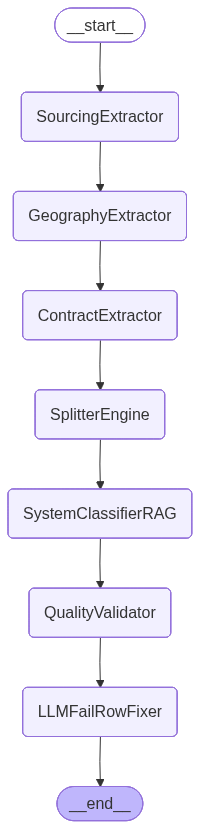

In [32]:
from IPython.display import Image, display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [26]:
# 10) GRAPH EXPORT (OFFLINE SAFE)

def export_workflow_mermaid(app_obj, out_file="workflow.mmd"):
    mmd = app_obj.get_graph().draw_mermaid()
    with open(out_file, "w", encoding="utf-8") as f:
        f.write(mmd)
    print(f"Workflow Mermaid saved locally: {out_file}")
    return out_file

In [27]:
# 11) EXCEL HIGHLIGHTING FEATURE

def highlight_evidence_reason_columns(excel_path: str):
    wb = load_workbook(excel_path)

    # ✅ Always ensure at least one visible sheet
    ws = wb.active
    ws.sheet_state = "visible"

    header = [cell.value for cell in ws[1]]

    evidence_cols = []
    reason_cols = []

    for idx, col_name in enumerate(header, start=1):
        if isinstance(col_name, str) and "Evidence" in col_name:
            evidence_cols.append(idx)
        if isinstance(col_name, str) and "Reason" in col_name:
            reason_cols.append(idx)

    evidence_fill = PatternFill(start_color="FFF2CC", end_color="FFF2CC", fill_type="solid")
    reason_fill = PatternFill(start_color="D9E1F2", end_color="D9E1F2", fill_type="solid")
    header_font = Font(bold=True)

    for col_idx in evidence_cols:
        ws.cell(row=1, column=col_idx).fill = evidence_fill
        ws.cell(row=1, column=col_idx).font = header_font

    for col_idx in reason_cols:
        ws.cell(row=1, column=col_idx).fill = reason_fill
        ws.cell(row=1, column=col_idx).font = header_font

    for row in range(2, ws.max_row + 1):
        for col_idx in evidence_cols:
            ws.cell(row=row, column=col_idx).fill = evidence_fill
        for col_idx in reason_cols:
            ws.cell(row=row, column=col_idx).fill = reason_fill

    wb.save(excel_path)
    print("Evidence + Reason columns highlighted successfully.")


In [28]:
# 12) MAIN EXECUTION

if __name__ == "__main__":

    print(f"\n📌 Loading Input File: {INPUT_EXCEL_PATH}")

    export_workflow_mermaid(app, out_file="workflow.mmd")

    try:
        df_input = pd.read_excel(INPUT_EXCEL_PATH)

        required_cols = ["Source URL", "Contract Date", "Contract Description"]
        if not all(col in df_input.columns for col in required_cols):
            raise ValueError(f"Excel file must contain columns: {required_cols}")

        print(f"🚀 Processing {len(df_input)} rows...")
        results = []

        for index, row in df_input.iterrows():
            print(f"\n🔹 Row {index + 1}/{len(df_input)}")

            desc = str(row["Contract Description"]) if pd.notna(row["Contract Description"]) else ""
            c_date = str(row["Contract Date"]) if pd.notna(row["Contract Date"]) else str(datetime.date.today())
            c_url = str(row["Source URL"]) if pd.notna(row["Source URL"]) else ""

            initial_state: AgentState = {
                "input_text": desc,
                "input_date": c_date,
                "input_url": c_url,

                "final_data": {},
                "final_rows": [],
                "validated_rows": [],
                "final_rows_post_llm": [],

                "messages": []
            }

            output_state = app.invoke(initial_state)

            rows = output_state.get("final_rows_post_llm", [])
            if not rows:
                rows = output_state.get("validated_rows", [])
            if not rows:
                rows = output_state.get("final_rows", [])
            if not rows:
                rows = [output_state.get("final_data", {})]

            results.extend(rows)

        df_final = pd.DataFrame(results)

        FINAL_COLUMNS = [
            "Customer Region", "Customer Country", "Customer Operator",
            "Supplier Region", "Supplier Country", "Domestic Content",

            "Split Flag", "Split Reason",

            "Market Segment", "Market Segment Evidence", "Market Segment Reason",
            "System Type (General)", "System Type (General) Evidence", "System Type (General) Reason",
            "System Type (Specific)", "System Type (Specific) Evidence", "System Type (Specific) Reason",
            "System Name (General)", "System Name (General) Evidence", "System Name (General) Reason",
            "System Name (Specific)", "System Name (Specific) Evidence", "System Name (Specific) Reason",
            "System Piloting", "System Piloting Evidence", "System Piloting Reason",
            "Confidence",

            "Supplier Name", "Supplier Name Evidence",
            "Program Type", "Expected MRO Contract Duration (Months)",
            "Quantity", "Value Certainty", "Value (Million)", "Currency",
            "Value (USD$ Million)", "Value Note (If Any)", "G2G/B2G",
            "Signing Month", "Signing Year",

            "QA Status", "QA Flags", "QA Fix Suggestion",
            "LLM QA Fix Summary",

            "Description of Contract",
            "Additional Notes (Internal Only)",
            "Source Link(s)",
            "Contract Date",
            "Reported Date (By SGA)"
        ]

        df_final = df_final.reindex(columns=FINAL_COLUMNS, fill_value="")
        OUTPUT_CSV_PATH = "Processed_Defense_Data.csv"
        df_final.to_csv(OUTPUT_CSV_PATH, index=False, encoding="utf-8-sig")
        print("\n Processing Complete!")
        print(f" Output CSV Saved: {OUTPUT_CSV_PATH}")
        print(df_final.head(3).to_string(index=False))

    except Exception as e:
        print(f"\n ERROR: {e}")


📌 Loading Input File: /content/source_file.xlsx
Workflow Mermaid saved locally: workflow.mmd
🚀 Processing 3 rows...

🔹 Row 1/3


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
  "System Name (General) Evidence": "General Dynamics NASSCO \u2013 San Diego, San Diego, California, is awarded a $98,749,123, firm-fixed-price contract for the execution of the USS Pinckney (DDG 91) FY22 depot modernization period.",
  "System Name (General) Reason": "The USS Pinckney is part of the Arleigh Burke-class of destroyers.",
  "System Name (Specific)": "USS Pinckney (DDG-91)",
  "System Name (Specific) Evidence": "General Dynamics NASSCO \u2013 San Diego, San Diego, California, is awarded a $98,749,123, firm-fixed-price contract for the execution of the USS Pinckney (DDG 91) FY22 depot modernization period.",
  "System Name (Specific) Reason": "The contract specifically mentions the USS Pinckney (DDG 91) as the system being modernized.",
  "System Piloting": "Crewed",
  "System Piloting Evidence": "Not Found",
  "System Piloting Reason": "Not Found",
  "Confidence": "High"
}

AI RESPONSE (Stage7 - LLM FAIL FIX) | Chunk 1
{

KeyboardInterrupt: 